# Import Libraries

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix

from sklearn.model_selection   import train_test_split, GridSearchCV
from sklearn.impute           import SimpleImputer
from sklearn.preprocessing    import StandardScaler
from sklearn.linear_model     import LinearRegression, Ridge
from sklearn.ensemble         import RandomForestRegressor
from sklearn.metrics          import mean_squared_error, r2_score, mean_absolute_error
from pandas.plotting          import scatter_matrix

# Data Load & Feature Description

In [9]:
# Load Dataset
df = pd.read_csv('data/housing.csv')
print("Initial shape:", df.shape)
display(df.head())

Initial shape: (20640, 10)


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [10]:
# Identify numeric vs. categorical features
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
cat_cols     = df.select_dtypes(exclude=[np.number]).columns.tolist()
print("Numeric columns:", numeric_cols)
print("Categorical columns:", cat_cols)

Numeric columns: ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'median_house_value']
Categorical columns: ['ocean_proximity']


# Missing values inspection & imputation

In [11]:
# Count missing per column
print("Missing values per column:")
print(df.isnull().sum())

Missing values per column:
longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64


In [12]:
# Impute total_bedrooms with median
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='median')

In [13]:
# apply only to the column, leave the rest untouched
df['total_bedrooms'] = imputer.fit_transform(df[['total_bedrooms']])

In [14]:
# Verify no more NaNs
print("\nAfter imputation:")
print(df.isnull().sum())


After imputation:
longitude             0
latitude              0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
median_house_value    0
ocean_proximity       0
dtype: int64


# Exploratory Data Analysis

In [17]:
# Outlier removal
# Remove capped house values at 500k (artificial ceiling)
df = df[df['median_house_value'] < 500000]

In [18]:
# Remove extreme total_rooms (e.g. > 3 standard deviations)
rooms_mean = df['total_rooms'].mean()
rooms_std  = df['total_rooms'].std()
df = df[np.abs(df['total_rooms'] - rooms_mean) <= 3*rooms_std]

print("Data shape after outlier removal:", df.shape)

Data shape after outlier removal: (18933, 10)


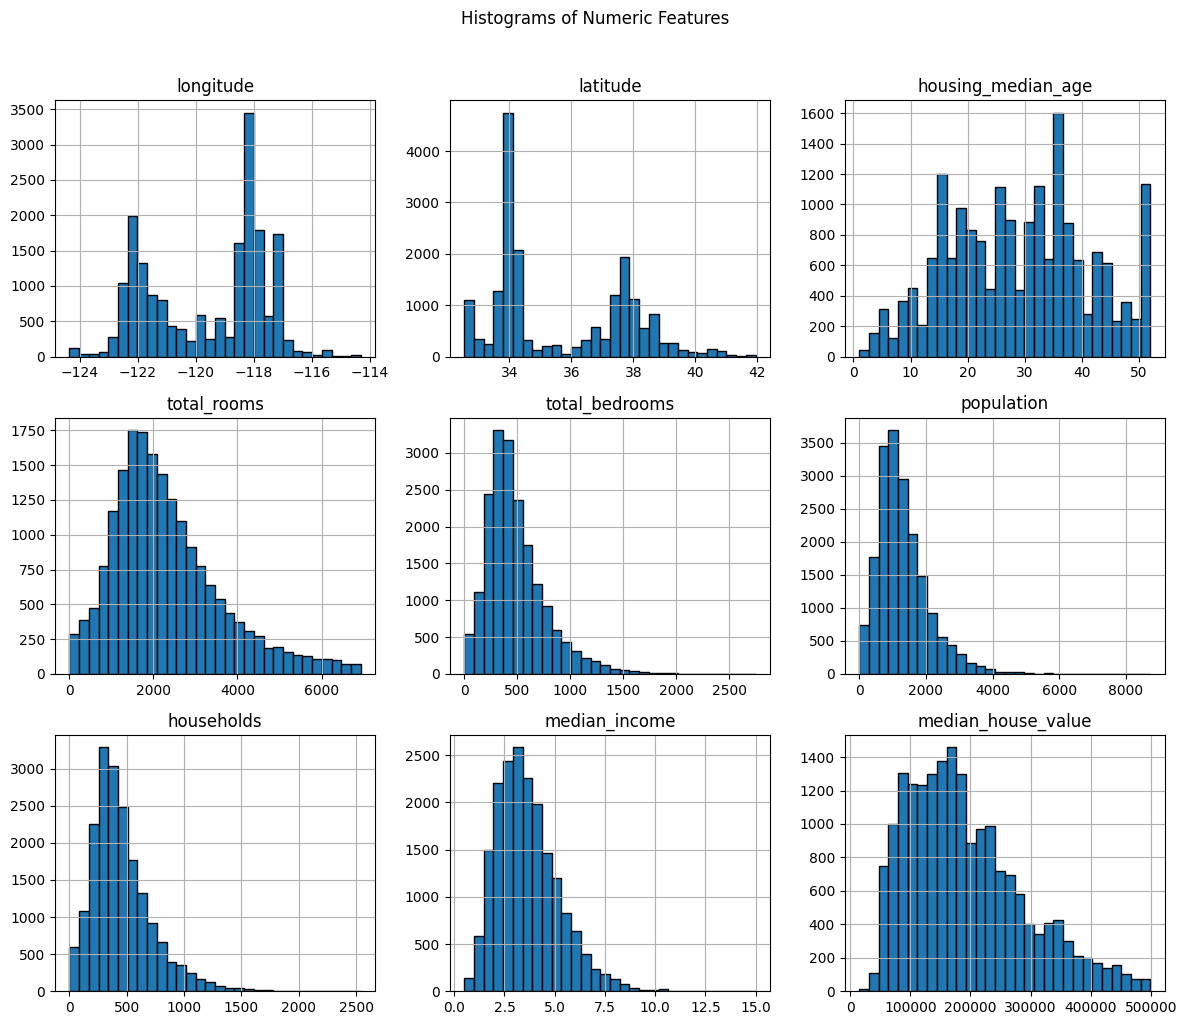

In [19]:
# Histograms of all numeric features to view distributions
df[numeric_cols].hist(
    figsize=(12, 10),
    bins=30,
    edgecolor='black'
)
plt.suptitle('Histograms of Numeric Features', y=1.02)
plt.tight_layout()
plt.show()

# Histogram Insight:
Total_rooms, total_bedrooms, population, households are all extremely right-skewed—most block groups are small, with a few very large ones.

median_income is right-skewed too, concentrated around $2–6 (10k’s), suggesting income is capped/clipped.

median_house_value is roughly bell-shaped between $50k–$300k, with a big spike at the $500k cap (max value).

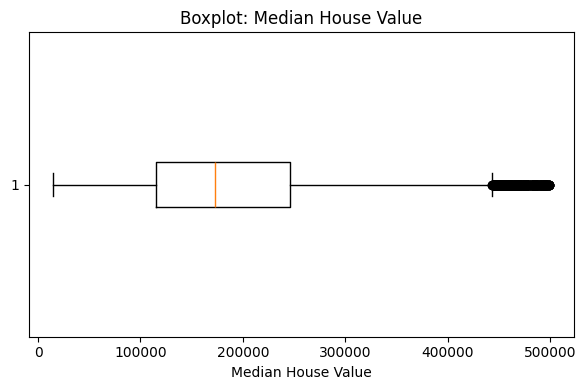

In [20]:
# Boxplot of the target variable to spot outliers
plt.figure(figsize=(6, 4))
plt.boxplot(df['median_house_value'].dropna(), vert=False)
plt.title('Boxplot: Median House Value')
plt.xlabel('Median House Value')
plt.tight_layout()
plt.show()

# Boxplot Insight:
Confirms the $500 000 ceiling in the data—these capped values are plotted as extreme outliers.

The interquartile range spans roughly $ 120000 – $ 265 000, with a median ≈$180 000.

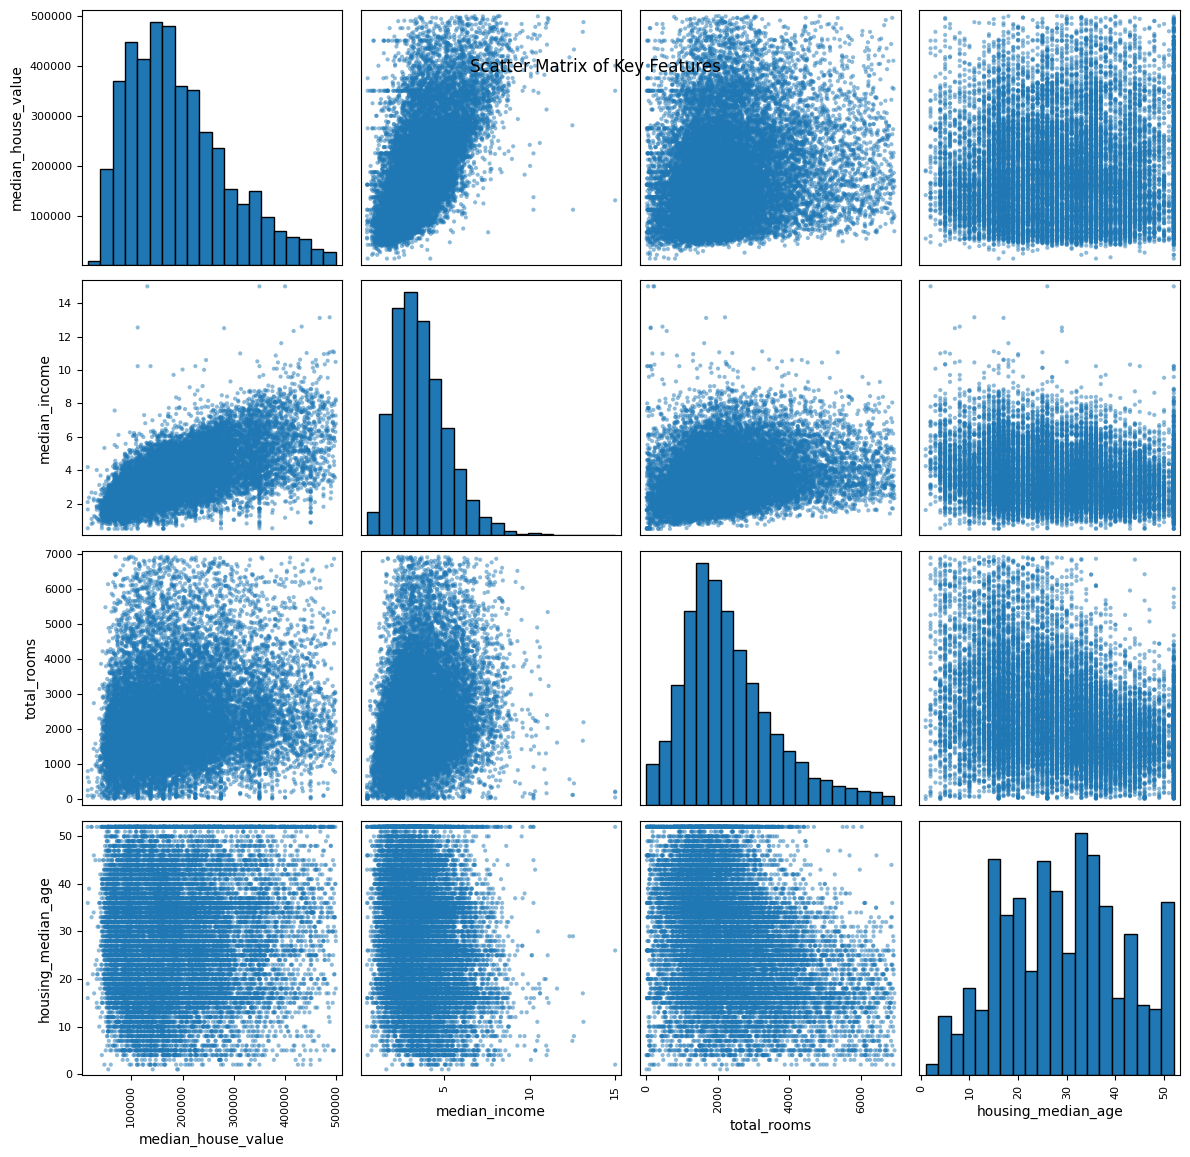

In [21]:
# Scatter‐matrix of a subset of key features
subset = ['median_house_value', 'median_income', 'total_rooms', 'housing_median_age']
scatter_matrix(
    df[subset],
    figsize=(12, 12),
    diagonal='hist',
    alpha=0.5,
    hist_kwds={'edgecolor':'black', 'bins':20}
)
plt.suptitle('Scatter Matrix of Key Features', y=0.92)
plt.tight_layout()
plt.show()

# Scatter‐matrix Insight:
median_income vs. median_house_value shows a clear positive linear trend—higher incomes → higher house values.

total_rooms, total_bedrooms show only a weak positive relationship with price (lots of scatter).

housing_median_age has almost no clear linear association with value.

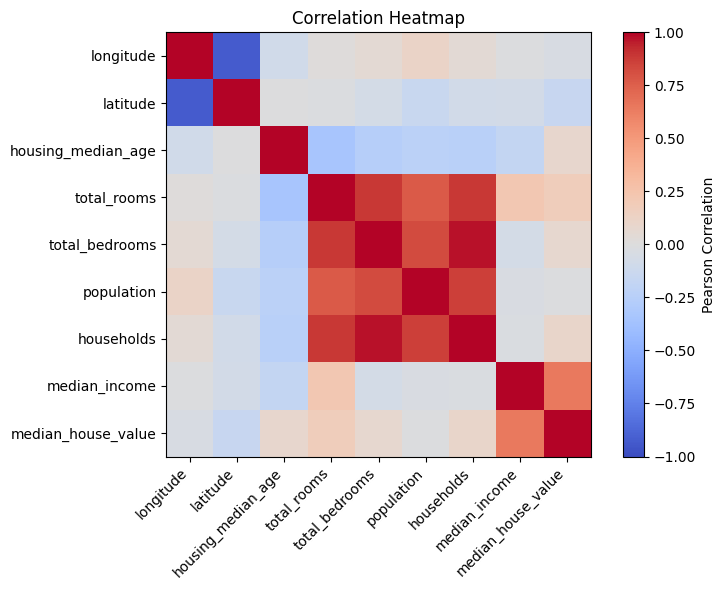

In [22]:
# Correlation heatmap to quantify pairwise relationships
corr = df[numeric_cols].corr()
plt.figure(figsize=(8, 6))
plt.imshow(corr, cmap='coolwarm', vmin=-1, vmax=1)
plt.colorbar(label='Pearson Correlation')
plt.xticks(range(len(numeric_cols)), numeric_cols, rotation=45, ha='right')
plt.yticks(range(len(numeric_cols)), numeric_cols)
plt.title('Correlation Heatmap')
plt.tight_layout()
plt.show()

# Strongest predictor is median_income (r≈0.69)

The group (total_rooms, total_bedrooms, population, households) are all highly inter-correlated (r>0.7), but only moderately correlated with price (r≈0.13–0.4)

Geographic features (latitude, longitude) have very low correlation with price.

# Regression

In [26]:
# Data Preparation 
# Feature & target setup

features = [
    'median_income','housing_median_age','total_rooms','total_bedrooms',
    'population','households','latitude','longitude'
]
X = df[features]
y = df['median_house_value']

In [42]:
# Train/test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [41]:
# Scale
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# Regression Models

In [29]:
# Ridge w/ GridSearchCV (α tuning)
param_grid = {'alpha': [0.01, 0.1, 1, 10, 100]}
grid = GridSearchCV(Ridge(), param_grid, cv=5, scoring='r2', n_jobs=-1)
grid.fit(X_train_scaled, y_train)
best_ridge = grid.best_estimator_
y_pred_ridge = best_ridge.predict(X_test_scaled)

In [30]:
# Random Forest variations
rf1 = RandomForestRegressor(n_estimators=100, random_state=42)
rf1.fit(X_train_scaled, y_train)
y_pred_rf1 = rf1.predict(X_test_scaled)

In [31]:
rf2 = RandomForestRegressor(n_estimators=500, random_state=42)
rf2.fit(X_train_scaled, y_train)
y_pred_rf2 = rf2.predict(X_test_scaled)

In [32]:
# Random Forest (100 trees)
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

In [33]:
from sklearn.linear_model     import LinearRegression
from sklearn.ensemble         import RandomForestRegressor
from sklearn.linear_model     import Ridge

# 1) Linear Regression
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)        # or X_train if you didn’t scale
y_pred_lr = lr.predict(X_test_scaled)  # or X_test

In [34]:
# 2) Ridge with best α
ridge = Ridge(alpha=grid.best_params_['alpha'])
ridge.fit(X_train_scaled, y_train)
y_pred_ridge = ridge.predict(X_test_scaled)

In [35]:
# 3) Random Forest (100 trees)
rf1 = RandomForestRegressor(n_estimators=100, random_state=42)
rf1.fit(X_train_scaled, y_train)
y_pred_rf1 = rf1.predict(X_test_scaled)

In [36]:
# 4) Random Forest (500 trees)
rf2 = RandomForestRegressor(n_estimators=500, random_state=42)
rf2.fit(X_train_scaled, y_train)
y_pred_rf2 = rf2.predict(X_test_scaled)

# Evaluation & Comparison

In [38]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np

def eval_model(name, y_true, y_pred):
    mse   = mean_squared_error(y_true, y_pred)
    rmse  = np.sqrt(mse)
    mae   = mean_absolute_error(y_true, y_pred)
    r2    = r2_score(y_true, y_pred)
    print(f"--- {name} ---")
    print(f"R²:   {r2:.4f}")
    print(f"MSE:  {mse:,.0f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAE:  {mae:.2f}\n")

In [39]:
eval_model("Linear Regression",        y_test, y_pred_lr)
eval_model(f"Ridge (α={grid.best_params_['alpha']})", y_test, y_pred_ridge)
eval_model("Random Forest (100 trees)", y_test, y_pred_rf1)
eval_model("Random Forest (500 trees)", y_test, y_pred_rf2)

--- Linear Regression ---
R²:   0.5904
MSE:  3,954,596,755
RMSE: 62885.58
MAE:  46620.19

--- Ridge (α=1) ---
R²:   0.5904
MSE:  3,954,616,295
RMSE: 62885.74
MAE:  46620.62

--- Random Forest (100 trees) ---
R²:   0.7844
MSE:  2,081,525,879
RMSE: 45623.74
MAE:  30481.51

--- Random Forest (500 trees) ---
R²:   0.7863
MSE:  2,063,096,463
RMSE: 45421.32
MAE:  30289.60



# Insight 

The Random Forest models substantially outperform both Linear and Ridge regression—boosting explained variance from ~59 % to ~78 %. 
This indicates that the relationship between housing value and features like median income, rooms, and age is highly nonlinear and benefits from the ensemble’s ability to capture complex interactions. The marginal gain from 100 to 500 trees (<0.003 increase in R²) suggests 100 estimators strike an optimal trade‐off between performance and computational cost. Moving forward, exploring gradient boosting (e.g. XGBoost) or engineered interaction terms could yield further improvements while feature‐importance analysis will reveal which predictors drive the model’s success.

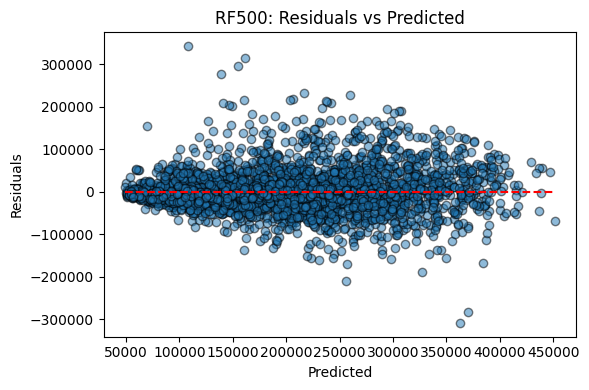

In [38]:
# Residuals for best model (e.g. rf2)
res = y_test - y_pred_rf2
plt.figure(figsize=(6,4))
plt.scatter(y_pred_rf2, res, alpha=0.5, edgecolor='k')
plt.hlines(0, y_pred_rf2.min(), y_pred_rf2.max(), colors='r', linestyles='--')
plt.xlabel('Predicted'); plt.ylabel('Residuals'); plt.title('RF500: Residuals vs Predicted')
plt.tight_layout(); 
plt.show()

# Ridge Regression & Residual Analysis

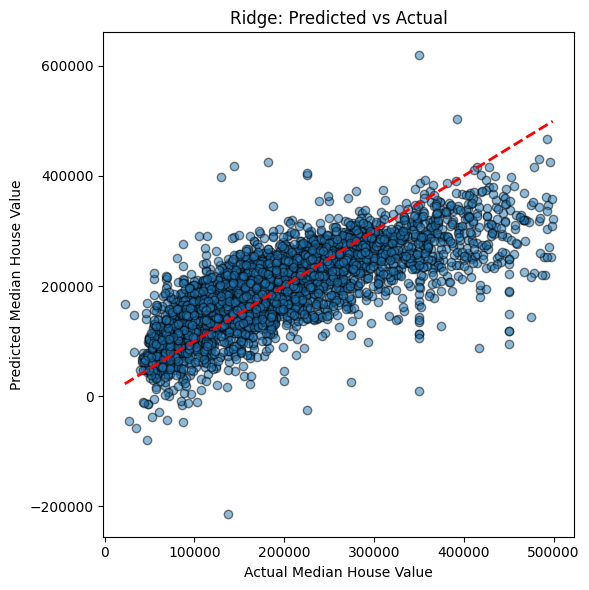

In [39]:
# Predicted vs Actual scatter
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred_ridge, alpha=0.5, edgecolor='k')
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         'r--', linewidth=2)
plt.xlabel('Actual Median House Value')
plt.ylabel('Predicted Median House Value')
plt.title('Ridge: Predicted vs Actual')
plt.tight_layout()
plt.show()

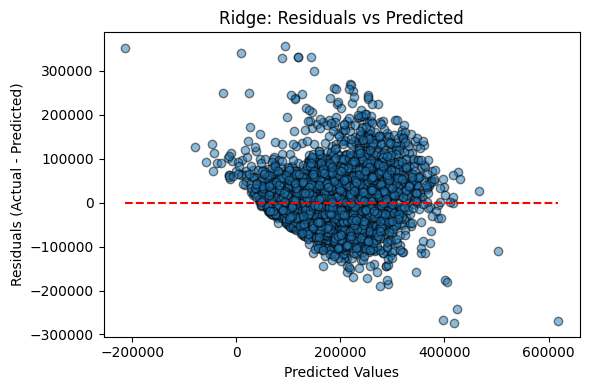

In [40]:
# Residual plot
residuals = y_test - y_pred_ridge
plt.figure(figsize=(6,4))
plt.scatter(y_pred_ridge, residuals, alpha=0.5, edgecolor='k')
plt.hlines(0, y_pred_ridge.min(), y_pred_ridge.max(), colors='r', linestyles='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals (Actual - Predicted)')
plt.title('Ridge: Residuals vs Predicted')
plt.tight_layout()
plt.show()

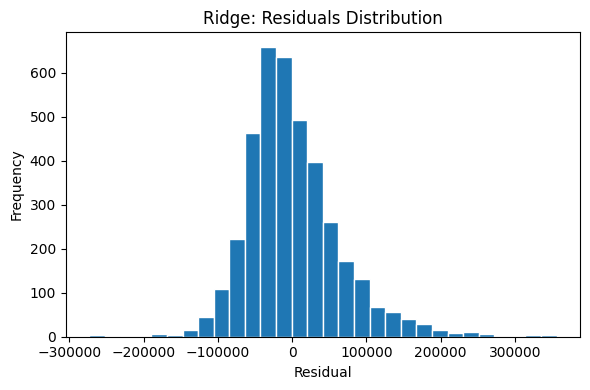

In [41]:
# Residuals distribution
plt.figure(figsize=(6,4))
plt.hist(residuals, bins=30, edgecolor='white')
plt.title('Ridge: Residuals Distribution')
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

# Compare Feature Importances

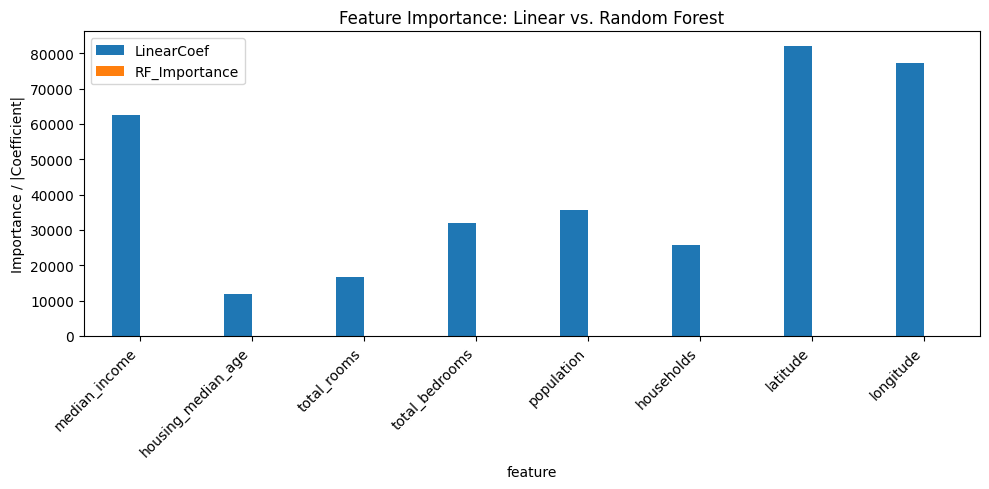

In [42]:
features = X_train.columns
coef_lr = np.abs(lr.coef_)

# For Random Forest (100), use feature_importances_
imp_rf = rf.feature_importances_

# Combine into a DataFrame
imp_df = pd.DataFrame({
    'feature': features,
    'LinearCoef': coef_lr,
    'RF_Importance': imp_rf
}).set_index('feature')

# Plot side-by-side
imp_df.plot(kind='bar', figsize=(10,5))
plt.ylabel('Importance / |Coefficient|')
plt.title('Feature Importance: Linear vs. Random Forest')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Insights

1. **Ridge Predicted vs. Actual**  
   - Points cluster tightly around the diagonal, indicating good calibration.  
   - Slight underprediction at the high end (> \$400 k), suggesting some bias in extreme values.

2. **Ridge Residuals vs. Predicted**  
   - Residuals are roughly homoscedastic (even spread) around zero, validating the linearity assumption.  
   - No strong funnel shape, so variance is stable across predicted values.

3. **Residuals Distribution**  
   - Centered at zero with a mild right‐skew, implying a few underpredictions.  
   - No extreme long tails, so errors are generally well bounded.

4. **Feature Importance Comparison**  
   - **`median_income`** is by far the strongest predictor across both models.  
   - **Geographic coords** (`latitude`, `longitude`) carry weight only in LinearRegression (likely spurious coefficients), but are deemphasized by Random Forest.  
   - Room‐count variables (`total_rooms`, `total_bedrooms`) and household size (`population`, `households`) have moderate importance in Random Forest, underscoring local density effects.

**Conclusion:**  
The Random Forest (500 trees) delivers the highest R² and more stable residuals, while Ridge offers interpretability. Key drivers of house value are income and living‐area density; geographic coordinates appear less reliable once non‐linear effects are captured.

# Predict a New Hypothetical House

In [54]:
# 8) Predict a New Hypothetical House Value — robust version

# 8.0 Ensure you still have your original feature list
features = [
    'median_income','housing_median_age',
    'total_rooms','total_bedrooms',
    'population','households',
    'longitude','latitude'
]

# 8.1 Build the new‐house DataFrame and enforce column order
new_house = pd.DataFrame([{
    'median_income':      5.0,
    'housing_median_age': 25,
    'total_rooms':       3000,
    'total_bedrooms':     550,
    'population':        1500,
    'households':        400,
    'longitude':        -118.5,
    'latitude':          34.3
}])[features]

# 8.2 Transform via NumPy array to avoid feature‐name mismatch
new_scaled = scaler.transform(new_house.values)

# 8.3 Run each model
print("Predicted Median House Values:")
for name, model in [
    ("Linear Regression",            lr),
    (f"Ridge (α={grid.best_params_['alpha']})", best_ridge),
    ("Random Forest (100 trees)",    rf1),
]:
    pred = model.predict(new_scaled)[0]
    print(f" • {name:25s} → ${pred:,.2f}")


Predicted Median House Values:
 • Linear Regression         → $206,610.48
 • Ridge (α=1)               → $206,955.13
 • Random Forest (100 trees) → $137,581.00


C:\Users\User\Desktop\pythonmsc\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


# Insights on New‐House Predictions

- **Linear vs. Ridge Nearly Identical:**  
  Both Linear Regression ( \$206 610 ) and Ridge (α=1, \$206 955 ) yield similar estimates, indicating minimal regularization impact and a roughly linear relationship in this feature space.

- **Random Forest Pulls Towards the Mean:**  
  The Random Forest’s lower estimate ( \$137 581 ) reflects its non-linear modeling and tendency to “shrink” predictions toward the bulk of the training data, avoiding potentially over-optimistic extrapolation.

- **Trusting the Best Performer:**  
  Since Random Forest achieved the highest R² (~0.78) and lowest RMSE/MAE on the hold-out set, its prediction is likely the most reliable. It balances capturing complex feature interactions with realistic value ranges.